In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv, det
import numpy as np
from scipy.special import logit, expit
from scipy.stats import norm
from tqdm.notebook import tqdm
import random

#**Overlapping class distributions**

Text(0.5, 1.0, 'Training data')

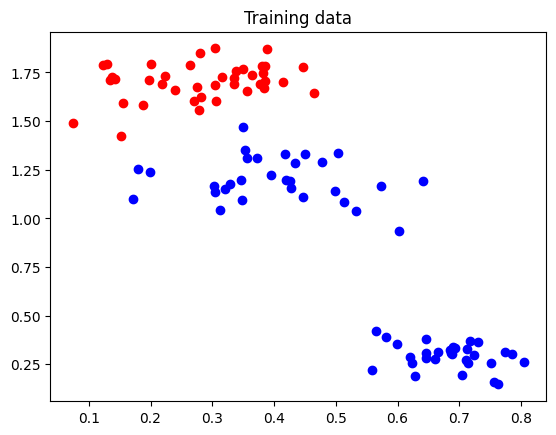

In [ ]:
def getData(n, pi, add_outlier = False):
  size1 = int(n * pi)
  size2 = n - int(n * pi)

  X1 = np.random.normal(0.3, 0.1, size1)
  X2 = np.random.normal(1.7, 0.1, size1)
  Y = np.array([1 for i in range(0, size1)])

  if not add_outlier:
    X1 = np.concatenate((X1, np.random.normal(0.4, 0.1, size2)), axis=0)
    X2 = np.concatenate((X2, np.random.normal(1.2, 0.1, size2)), axis=0)
    Y = np.concatenate((Y, np.array([-1 for i in range(0, size2)])), axis=0)
  else:
    size2_1 = (n - int(n * pi)) // 2
    size2_2 = n - size1 - size2_1
    # half are outlier data
    X1 = np.concatenate((X1, np.random.normal(0.4, 0.1, size2_1)), axis=0)
    X2 = np.concatenate((X2, np.random.normal(1.2, 0.1, size2_1)), axis=0)
    Y = np.concatenate((Y, np.array([-1 for i in range(0, size2_1)])), axis=0)

    X1 = np.concatenate((X1, np.random.normal(0.7, 0.06, size2_2)), axis=0)
    X2 = np.concatenate((X2, np.random.normal(0.3, 0.06, size2_2)), axis=0)
    Y = np.concatenate((Y, np.array([-1 for i in range(0, size2_2)])), axis=0)

  return np.concatenate((X1[:, np.newaxis], X2[:, np.newaxis]), axis=1), np.array(Y[:, np.newaxis])

def plot_data(x, y, size, criterian):
  for i in range(size):
    if y[i] > criterian:
      plt.scatter(x[i, 0], x[i, 1], color = 'red')
    else:
      plt.scatter(x[i, 0], x[i, 1], color = 'blue')


train_size = 100
ratio = 0.4
x_train, t_train = getData(train_size, ratio, True)
t_train = t_train.reshape(train_size)
plt.figure(1)
plot_data(x_train, t_train, train_size, 0.0)
plt.title("Training data")


#**SMO SVM classification**

Reference: https://zhuanlan.zhihu.com/p/410426229

Idea: We have n multipliers to update. Let's consider only one multipler $a_i$ each time along with another $a_j$. For other multipliers, we simply treat them as constants.

Our goal is to update while satisfying KKT conditions. Thus, we can choose multipliers that don't satisfy KKT as $a_i$. We also pick a $a_j$ that maximize the gradient so that our program will be more efficient. After each update, we also need to clip them in order to make them satisfy KKT.

#KKT Conditions

The KKT conditions are from (7.23) to (7.28).

When $a_n = 0$, by (7.31) $\mu \ne 0$, so by (7.28) $\xi_n = 0$, which means $\space t_n y_n -1 \ge 0$ by (7.25)

When $a_n = C$, by (7.31) $\mu = 0$, so by (7.28) $\xi_n \ge 0$, which means $\space t_n y_n - 1 \le 0$ by (7.25)

When $0 \le a_n \le C$, by (7.31) $\mu \ne 0$, so by (7.28) $\xi_n = 0$, which means $\space t_n y_n - 1 = 0$ by (7.25)

#Selecting $i$ and $j$

Our goal is to make $t_n y_n = 1$ (7.7). So the difference, which is $abs(t_n y_n - 1)$, is the degree of violating KKT of $a_n$. And we set the degree to 0 if it satisfies the KKT conditions above.

We choose $a_i$ that has the highest degree of violating KKT.

And we choose a random $a_j$ that also violates KKT.

#*Update Contraint (Clip)*

*These are all old parameters.

We have a contraint $0 \le a_n \le C$. ($C$ is infinity in non misclassification case).

If we pick $a_i$ and $a_j$ while fixing other terms, we see that by (7.9), $t_i a_i + t_j a_j = k$ where $k$ is the negative sum of other terms. Which means:

$t_i = t_j \space\space → \space\space a_i + a_j = k \space\space → \space\space a_i = k - a_j$

$t_i \ne t_j \space\space → \space\space a_i - a_j = k \space\space → \space\space a_i = k + a_j$

We also have:

$0 \le a_j \le C$

Thus, we can do the following calculation:

When $t_i \ne t_j$:

$0 + k\le a_j + k \le C + k$

$a_i - a_j \le a_i \le C + a_i - a_j$

When $t_i = t_j$:

$k - 0 \ge k - a_j \ge k - C$

$a_i + a_j \ge a_i \ge a_i + a_j - c$

And we get the upper and lower bound for $a_i$:

#When $t_i \ne t_j$:

#$L = max(0, a_i - a_j) \space \space \space H = min(C, C + a_i - a_j)$

#When $t_i = t_j$:

#$L = max(0, a_i + a_j - C) \space \space \space H = min(C, a_i + a_j)$



#*Update Function*

From (7.32), we eliminated w by plugging the zero-derivative solution in the original loss function to give:

$$\tilde{L}(a) = \sum_{n=1}^{N}a_n - \frac{1}{2}\sum_{n=1}^{N}\sum_{m=1}^{N}a_n a_m t_n t_m \mathbf{k}(x_n, x_m)$$

\\
**First, we rewrite the loss function to make $a_i$ and $a_j$ explicit:**

$$\tilde{L}(a) = a_i + a_j - \frac{1}{2}a_i a_i t_i t_i \mathbf{k}(x_i, x_i) - \frac{1}{2}a_j a_j t_j t_j \mathbf{k}(x_j, x_j) - a_i a_j t_i t_j \mathbf{k}(x_i, x_j) - a_i t_i \sum_{n \ne ij}^{N}a_n t_n \mathbf{k}(x_i, x_n) - a_j t_j \sum_{n \ne ij}^{N}a_n t_n \mathbf{k}(x_j, x_n) - constant$$

\\
**Second, we want to minimize it with respect to $a_i$. We know that: $t_i a_i + t_j a_j = k$. Thus we can replace $a_j$ with $a_i$:**

$$a_j = t_j(k - t_i a_i)$$

Which gives:

$$\tilde{L}(a) = a_i + t_j(k - t_i a_i) - \frac{1}{2}a_i a_i t_i t_i \mathbf{k}(x_i, x_i) - \frac{1}{2}t_j(k - t_i a_i) t_j(k - t_i a_i) t_j t_j \mathbf{k}(x_j, x_j) - a_i t_j(k - t_i a_i) t_i t_j \mathbf{k}(x_i, x_j) - a_i t_i\sum_{n \ne ij}^{N}a_n t_n k(x_i, x_n) - t_j(k - t_i a_i) t_j\sum_{n \ne ij}^{N}a_n t_n \mathbf{k}(x_j, x_n) - constant$$

As $t_i t_i = 1$, we further simplify:

$$\tilde{L}(a) = a_i + t_j(k - t_i a_i) - \frac{1}{2}a_i^2 \mathbf{k}(x_i, x_i) - \frac{1}{2}(k - t_i a_i)^2 \mathbf{k}(x_j, x_j) - a_i (k - t_i a_i) t_i \mathbf{k}(x_i, x_j) - a_i t_i \sum_{n \ne ij}^{N}a_n t_n \mathbf{k}(x_i, x_n) -(k - t_i a_i) \sum_{n \ne ij}^{N}a_n t_n \mathbf{k}(x_j, x_n) - constant$$

$$\tilde{L}(a) = a_i + t_jk - t_j t_i a_i - \frac{1}{2}a_i^2 \mathbf{k}(x_i, x_i) - \frac{1}{2}k^2 \mathbf{k}(x_j, x_j) + k t_i a_i \mathbf{k}(x_j, x_j) - \frac{1}{2}a_i^2 \mathbf{k}(x_j, x_j) - a_i k t_i \mathbf{k}(x_i, x_j) + a_i^2 \mathbf{k}(x_i, x_j) - a_i t_i \sum_{n \ne ij}^{N}a_n t_n \mathbf{k}(x_i, x_n) - k \sum_{n \ne ij}^{N}a_n t_n \mathbf{k}(x_j, x_n) + t_i a_i \sum_{n \ne ij}^{N}a_n t_n \mathbf{k}(x_j, x_n) - constant$$

\\
**Third, we take the derivative**

(Replace 1 with $t_i t_i$)

$$\frac{\delta\tilde{L}}{\delta a_i} = t_i t_i - t_j t_i - a_i \mathbf{k}(x_i, x_i) + k t_i \mathbf{k}(x_j, x_j) - a_i \mathbf{k}(x_j, x_j) - k t_i \mathbf{k}(x_i, x_j) + 2 a_i \mathbf{k}(x_i, x_j) - t_i \sum_{n \ne ij}^{N}a_n t_n \mathbf{k}(x_i, x_n) + t_i \sum_{n \ne ij}^{N}a_n t_n \mathbf{k}(x_j, x_n)$$

Set the derivative and pick out $a_i$, we get:

$$(\mathbf{K}_{ii} - 2\mathbf{K}_{ij} + \mathbf{K}_{jj}) a_i = t_i\{t_i - t_j + k \mathbf{K}_{jj} - k \mathbf{K}_{ij} - \sum_{n \ne ij}^{N}a_n t_n \mathbf{K}_{in} + \sum_{n \ne ij}^{N}a_n t_n \mathbf{K}_{jn}\}$$

Remember that out prediction function is (7.13):
$y(x) = \sum_{n}^{N}a_n t_n \mathbf{k}(x, x_n) + b$, which tells us:

$$\sum_{n \ne ij}^{N}a_n t_n \mathbf{k}(x, x_n) = y(x) - a_i t_i \mathbf{k}(x, x_i) - a_j t_j \mathbf{k}(x, x_j) - b$$

By replacing $x$ with $x_i$ and $x_j$, we get:

$$\sum_{n \ne ij}^{N}a_n t_n \mathbf{k}(x_i, x_n) = y(x_i) - a_i t_i \mathbf{k}(x_i, x_i) - a_j t_j \mathbf{k}(x_i, x_j) - b$$

$$\sum_{n \ne ij}^{N}a_n t_n \mathbf{k}(x_j, x_n) = y(x_j) - a_i t_i \mathbf{k}(x_j, x_i) - a_j t_j \mathbf{k}(x_j, x_j) - b$$

Now let's plug the result into the equation:

$$(\mathbf{K}_{ii} - 2\mathbf{K}_{ij} + \mathbf{K}_{jj}) a_i^{new} = t_i\{t_i - t_j + k \mathbf{K}_{jj} - k \mathbf{K}_{ij} - y(x_i) + a_i t_i \mathbf{K}_{ii} + a_j t_j \mathbf{K}_{ij} + b + y(x_j) - a_i t_i \mathbf{K}_{ji} - a_j t_j \mathbf{K}_{jj} - b\}$$

We also Plugin $k = t_i a_i + t_j a_j$ to get:

$$(\mathbf{K}_{ii} - 2\mathbf{K}_{ij} + \mathbf{K}_{jj}) a_i^{new} = t_i\{t_i - t_j + t_i a_i \mathbf{K}_{jj} + t_j a_j \mathbf{K}_{jj} - t_i a_i \mathbf{K}_{ij} - t_j a_j \mathbf{K}_{ij} - y(x_i) + a_i t_i \mathbf{K}_{ii} + a_j t_j \mathbf{K}_{ij} + b + y(x_j) - a_i t_i \mathbf{K}_{ji} - a_j t_j \mathbf{K}_{jj} - b\}$$

$$(\mathbf{K}_{ii} - 2\mathbf{K}_{ij} + \mathbf{K}_{jj}) a_i^{new} = t_i\{t_i - t_j + t_i a_i \mathbf{K}_{jj} - 2 t_i a_i \mathbf{K}_{ij} - y(x_i) + a_i t_i \mathbf{K}_{ii} + y(x_j)\}$$

$$(\mathbf{K}_{ii} - 2\mathbf{K}_{ij} + \mathbf{K}_{jj}) a_i^{new} = (\mathbf{K}_{ii} - 2\mathbf{K}_{ij} + \mathbf{K}_{jj})a_i + t_i\{(y(x_j) - t_j) - (y(x_i) - t_i)\}$$

**Finally, we get:**
#$$\eta = \mathbf{K}_{ii} - 2\mathbf{K}_{ij} + \mathbf{K}_{jj}$$

#$$En = y(x_n) - t_n$$

#$$a_i^{new} = a_i^{old} + \frac{t_i(E_j - E_i)}{\eta}$$

Also, as $$t_i a_i^{new} + t_j a_j^{new} = k = t_i a_i^{old} + t_j a_j^{old}$$

We get:

#$$a_j^{new} = a_j^{old} + t_i t_j (a_i^{old} - a_i^{new})$$

#Update b

By $y(x) = \sum_{n}^{N}a_n t_n \mathbf{k}(x, x_n) + b$, we can update b by:

$$b_i^{new} = y(x_i) - \sum_{n}^{N}a_n t_n \mathbf{k}(x_i, x_n)$$

$$b_i^{new} = y(x_i) - \sum_{n \ne ij}^{N}a_n t_n \mathbf{k}(x_i, x_n) - a_i^{new} t_i \mathbf{k}(x_i, x_i) - a_j^{new} t_j \mathbf{k}(x_i, x_j)$$

Remember:

$$E_i = \sum_{n \ne ij}^{N}a_n t_n \mathbf{k}(x_i, x_n) + a_i^{old} t_i \mathbf{k}(x_i, x_i) + a_j^{old} t_j \mathbf{k}(x_i, x_j) + b_i^{old} - t_i$$

$$\sum_{n \ne ij}^{N}a_n t_n \mathbf{k}(x_i, x_n)  = E_i - b_i^{old} + t_i - a_i^{old} t_i \mathbf{k}(x_i, x_i) - a_j^{old} t_j \mathbf{k}(x_i, x_j)$$

Thus by plugging it in, we get:

$$b_i^{new} = t_i - E_i + b_i^{old} - t_i + a_i^{old} t_i \mathbf{k}(x_i, x_i) + a_j^{old} t_j \mathbf{k}(x_i, x_j) - a_i^{new} t_i \mathbf{k}(x_i, x_i) - a_j^{new} t_j \mathbf{k}(x_i, x_j)$$

#$$b_i^{new} = b_i^{old} - E_i + (a_i^{old} - a_i^{new}) t_i \mathbf{k}(x_i, x_i) + (a_j^{old} - a_j^{new}) t_j \mathbf{k}(x_i, x_j)$$

#$$b_j^{new} = b_j^{old} - E_j + (a_i^{old} - a_i^{new}) t_i \mathbf{k}(x_j, x_i) + (a_j^{old} - a_j^{new}) t_j \mathbf{k}(x_j, x_j)$$

As every data shared the same $b$, we simply take the average:

#$$b^{new} = \frac{b_i^{new} + b_j^{new}}{2}$$

Finally, if there are support vectors, we get $b$ according to (7.18). Otherwise just keep the original value.

In [ ]:
# Code reference: https://github.com/chenhongkai/Freehand-Machine-Learning

def LinearKernelFunction(phi1, phi2):
  # K. n * n
  if phi1.ndim == 2 and phi2.ndim == 2:
    return phi1 @ phi2.T
  # k. n,
  elif phi1.ndim == 1 and phi2.ndim == 2:
    return phi2 @ phi1
  elif phi1.ndim == 2 and phi2.ndim == 1:
    return phi1 @ phi2
  # k. 1,
  elif phi1.ndim == 1 and phi2.ndim == 1:
    return phi1 * phi2


def PolyKernelFunction(phi1, phi2):
  # K(x_, z_) = (γ * x_ @ z_ + r)**d
  d = 2.0,
  r = 1.0,
  γ = 1.0,
  K = LinearKernelFunction(phi1, phi2)    # 线性核函数的输出
  K = (γ * K + r) ** d  # 多项式核函数的输出
  return K


def RBFKernelFunction(phi1, phi2):
  sigma = 1
  # K. n * n
  if phi1.ndim == 2 and phi2.ndim == 2:
    return np.exp(-1 / sigma**2 * ((phi1[:, np.newaxis, :] - phi2[np.newaxis, :, :])**2).sum(2))
  # k. n,
  elif phi1.ndim == 1 and phi2.ndim == 2:
    return np.exp(-1 / sigma**2 * ((phi2 - phi1[np.newaxis, :])**2).sum(1))
  elif phi1.ndim == 2 and phi2.ndim == 1:
    return np.exp(-1 / sigma**2 * ((phi1 - phi2[np.newaxis, :])**2).sum(1))
  # k. 1,
  elif phi1.ndim == 1 and phi2.ndim == 1:
    return np.exp(-1 / sigma**2 * ((phi1[np.newaxis, :] - phi2[np.newaxis, :])**2).sum(1))

In [ ]:
class SMOClassification:
  def __init__(self, C = 1.0, maxIterations = 50000, tol = 0.001):
    self.C = C
    self.maxIterations = maxIterations
    self.tol = tol
    self.b = None
    self.a_ = None
    self.supportVectors__ = None
    self.aSV_ = None
    self.tSV_ = None

    self.kernelFunction = LinearKernelFunction
    # self.kernelFunction = PolyKernelFunction
    # self.kernelFunction = RBFKernelFunction

  def fit(self, X__, t_):
    C = self.C
    N = len(X__)
    K__ = self.kernelFunction(X__, X__)
    a_ = np.zeros(N)
    b = 0.0
    for iter in range(1, self.maxIterations + 1):
      # y and E
        indexSV_ = np.where(a_ > 0)[0]   # Support vectors (an > 0)

        y_ = (a_[indexSV_]*t_[indexSV_]) @ K__[indexSV_, :] + b
        E_ = y_ - t_
        ty_ = t_ * y_

      # choose ai aj
        violateKKT_ = abs(1 - ty_)  # degree of violating KKT
        violateKKT_[(a_==0) & (ty_>=1)] = 0.0
        violateKKT_[(0<a_) & (a_<C) & (ty_==1)] = 0.0
        violateKKT_[(a_==C) & (ty_<=1)] = 0.0
        if violateKKT_.max() < self.tol:
          print(f'no more violation in the {iter}th iteration')
          break
        indexViolateKKT_ = np.where(violateKKT_>0)[0]

        i = violateKKT_.argmax()
        j = random.choice(indexViolateKKT_)

        while (X__[i]==X__[j]).all():
          j = random.choice(indexViolateKKT_)

      # Update ai aj
        aiOld, ajOld = a_[i], a_[j]
        if t_[i] != t_[j]:
          L, H = max(0, aiOld - ajOld), min(C, C + aiOld - ajOld)
        else:
          L, H = max(0, aiOld + ajOld - C), min(C, aiOld + ajOld)

        # Update ai
        η = K__[j, j] + K__[i, i] - 2 * K__[j, i]
        ai = aiOld + t_[i] * (E_[j] - E_[i]) / η
        # Clip ai
        if ai > H:
          ai = H
        elif ai < L:
          ai = L

        # Update aj
        aj = ajOld + t_[i] * t_[j] * (aiOld - ai)
        # Clip aj
        if aj > C:
          aj = C
        elif aj < 0:
          aj = 0

      # Update b
        bi = -E_[i] - t_[i]*K__[i, i]*(ai - aiOld) - t_[j]*K__[j, i]*(aj - ajOld) + b
        bj = -E_[j] - t_[i]*K__[j, i]*(ai - aiOld) - t_[j]*K__[j, j]*(aj - ajOld) + b

        b = (bi + bj) / 2
        a_[i], a_[j] = ai, aj

    indexSV_ = np.where(a_ > 0)[0]
    self.aSV_ = a_[indexSV_]
    self.tSV_ = t_[indexSV_]
    self.supportVectors__ = X__[indexSV_]
    self.a_ = a_
    indexNonBound_ = np.where((0 < a_) & (a_ < C))[0]
    if len(indexNonBound_) > 0:
      # (7.18)
      b_ = [(t_[k] - (self.aSV_*self.tSV_) @ K__[k, indexSV_]) for k in indexNonBound_]
      self.b = sum(b_)/len(b_)
    else:
      self.b = b

  def predict(self, X__):
    t_ = np.where(self.decisionFunction(X__) >= 0, 1, -1)
    return t_

  def decisionFunction(self, X__):
    return (self.aSV_ * self.tSV_) @ self.kernelFunction(self.supportVectors__, X__) + self.b

  def plot(self, X__, t_):
    plot_data(X__, t_, train_size, 0.0)
    plt.plot(self.supportVectors__[:, 0], self.supportVectors__[:, 1], 'ok', markersize=15, markerfacecolor='none')
    x0_ = np.linspace(0, 1, 100)
    x1_ = np.linspace(0, 2, 100)
    pred = [[self.decisionFunction(np.array([[x0, x1]]))[0] for x0 in x0_] for x1 in x1_]
    plt.contour(x0_, x1_, pred, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors=['b', 'k', 'r'])

no more violation in the 88th iteration


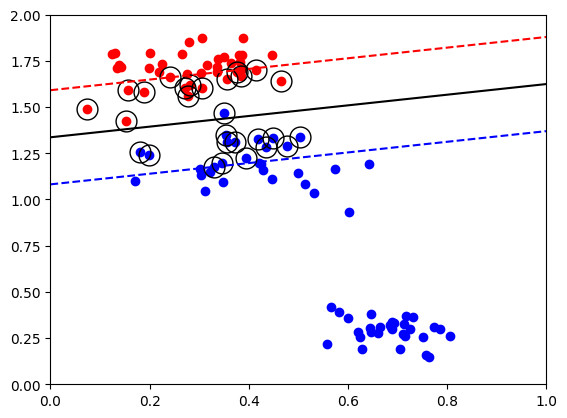

In [ ]:
model = SMOClassification()
model.fit(x_train, t_train)
model.plot(x_train, t_train)


#**SMO SVM Regression**

<ipython-input-2-0159eb537ef7>:15: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(-6, 6, 0.1)
<ipython-input-2-0159eb537ef7>:16: MatplotlibDeprecationWarning: Passing the emit parameter of set_ylim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.ylim(-10, 10, 0.1)


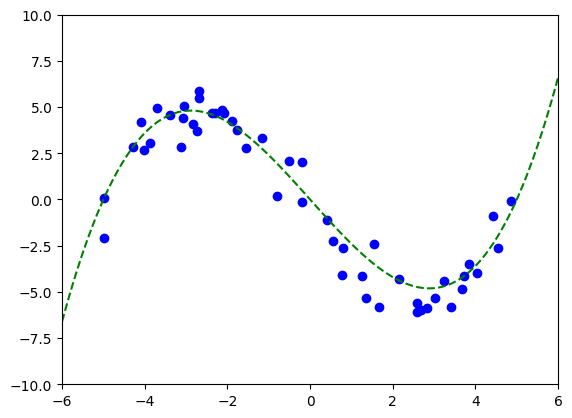

In [ ]:
# Precision for training data
sampleSize = 50

real_beta = (1.0)**2
x_train = np.random.uniform(-5, 5, sampleSize)
y_train = x_train * (x_train-5) * (x_train+5) / 10 + np.random.normal(0, 1 / real_beta**0.5, x_train.shape) # y = x(x-5)(x+5)
x_train = x_train[:, np.newaxis]

def plotTrainingFunction():
  x = np.linspace(-6, 6, 100)
  y = x * (x-5) * (x+5) / 10
  plt.plot(x, y, 'g--')

plt.figure(1)
plt.xlim(-6, 6, 0.1)
plt.ylim(-10, 10, 0.1)
plt.plot(x_train.reshape(sampleSize), y_train, 'bo')
plotTrainingFunction()

In [ ]:
from random import choice, uniform

from numpy import array, zeros, ones, ndarray, where, isnan, inf, intersect1d, block
import matplotlib.pyplot as plt


class SMORegression:
    """支持向量回归"""
    def __init__(self,
            C: float = 1.,    # 超参数：惩罚参数
            ε: float = 1.,    # 超参数：间隔带宽度为2ε
            maxIterations: int = 10000,  # 最大迭代次数
            tol: float = 1e-3,  # 收敛精度（指SMO求解算法当中最大违反KKT条件的程度）
            ):

        self.C = C  # 超参数：惩罚参数
        self.ε = ε  # 超参数：间隔带宽度为2ε
        self.maxIterations = maxIterations  # 最大迭代次数
        self.tol = tol       # 收敛精度（指SMO求解算法当中最大违反KKT条件的程度）
        self.M = None        # 输入特征向量的维数
        self.b = None        # 偏置
        self.α_ = None       # N维向量：N个训练样本的拉格朗日乘子
        self.αhat_ = None    # N维向量：N个训练样本的拉格朗日乘子
        self.ΔαSV_ = None    # N维向量：所有支持向量对应的αhat-α值
        self.supportVectors__ = None  # 矩阵：所有支持向量
        self.αSV_ = None     # 向量：所有支持向量对应的拉格朗日乘子α
        self.ySV_ = None     # 向量：所有支持向量对应的标签
        # self.kernelFunction = LinearKernelFunction
        # self.kernelFunction = PolyKernelFunction
        self.kernelFunction = RBFKernelFunction

    def fit(self, X__: ndarray, y_: ndarray):
        self.M = X__.shape[1]   # 输入特征向量的维数
        self.SMO(X__, y_)
        return self

    def SMO(self, X__: ndarray, y_: ndarray):
        """使用SMO（Sequential Minimal Optimization）算法求解对偶优化问题，最小化目标函数"""
        C = self.C      # 读取：惩罚参数
        ε = self.ε      # 读取：ε间隔带半宽度
        N = len(X__)    # 训练样本数量
        c_ = block([y_ - ε, -(y_ + ε)])      # 2N维向量：引入向量c_
        z_ = block([ones(N), -ones(N)])      # 2N维向量：引入向量z_
        K__ = self.kernelFunction(X__, X__)  # N×N矩阵：核函数矩阵
        K__ = block([[K__, K__],
                     [K__, K__]])  # 2N×2N矩阵：扩展的核函数矩阵
        λ_ = zeros(2*N)  # 2N维向量：初始化2N个拉格朗日乘子，即αhat_和α_
        b = 0            # 初始化偏置
        for t in range(1, self.maxIterations + 1):
            indexSV_ = where(λ_>0)[0]                   # 数组索引：满足λ>0的支持向量

            g_ = (λ_[indexSV_]*z_[indexSV_]) @ K__[indexSV_, :] + b  # 2N维向量：g(xi)值，i=1~N
            zg_ = z_*g_                                   # 2N维向量：zi*g(xi), i = 1~N
            violateKKT_ = abs(c_ - zg_)                   # 2N维向量：开始计算“违反KKT条件的程度”
            violateKKT_[(λ_==0) & (zg_>=c_)] = 0.         # 2N维向量：KKT条件 λ=0 ←→ z*g(x)≥c
            violateKKT_[(0<λ_) & (λ_<C) & (zg_==c_)] = 0. # 2N维向量：KKT条件 0<λ<C ←→ z*g(x)=c
            violateKKT_[(λ_==C) & (zg_<=c_)] = 0.         # 2N维向量：KKT条件 λ=C ←→ z*g(x)≤c
            if violateKKT_.max()<self.tol:
                print(f'第{t}次SMO迭代，最大违反KKT条件程度达到收敛精度{self.tol}，停止迭代!')
                break

            indexViolateKKT_ = where(violateKKT_>0)[0]    # 数组索引：找出违反KKT条件的λ
            i = violateKKT_.argmax()
            j = choice(indexViolateKKT_)  # 随机选择另一个违反KKT条件的λ
            while (X__[i % N]==X__[j % N]).all():
                j = choice(indexViolateKKT_)      # 所选样本X__[i]、X__[j]完全相同，重新选择λj


            λiOld, λjOld = λ_[i], λ_[j]   # 记录λi, λj的旧值
            if z_[i]!=z_[j]:              # 确定λj的下限L、上限H
                L, H = max(0, λjOld - λiOld), min(C, C + λjOld - λiOld)
            else:
                L, H = max(0, λjOld + λiOld - C), min(C, λjOld + λiOld)
            Kii = K__[i, i]  # 从核矩阵读取核函数值
            Kjj = K__[j, j]  # 从核矩阵读取核函数值
            Kij = K__[i, j]  # 从核矩阵读取核函数值
            Ei = g_[i] - c_[i]*z_[i]   # 误差值Ei
            Ej = g_[j] - c_[j]*z_[j]   # 误差值Ej
            η = Kii + Kjj - 2*Kij      # ||φ(xi)-φ(xj)||**2 >= 0
            λj = λjOld + z_[j]*(Ei - Ej)/η  # 未剪辑的λj
            if λj>H:     # 剪辑λj
                λj = H
            elif λj<L:
                λj = L
            else:
                pass
            λi = λiOld + z_[i]*z_[j]*(λjOld - λj) # 未剪辑的λi
            if λi>C:     # 剪辑λi
                λi = C
            elif λi<0:
                λi = 0
            else:
                pass
            λ_[i], λ_[j] = λi, λj  # 更新λi、λj

            if 0<λi<C:
                b =  -Ei - z_[i]*Kii*(λ_[i] - λiOld) - z_[j]*Kij*(λ_[j] - λjOld) + b
            elif 0<λj<C:
                b =  -Ej - z_[i]*Kij*(λ_[i] - λiOld) - z_[j]*Kjj*(λ_[j] - λjOld) + b
            else:
                bi = -Ei - z_[i]*Kii*(λ_[i] - λiOld) - z_[j]*Kij*(λ_[j] - λjOld) + b
                bj = -Ej - z_[i]*Kij*(λ_[i] - λiOld) - z_[j]*Kjj*(λ_[j] - λjOld) + b
                b = (bi + bj)/2


        self.αhat_ = λ_[:N]                                    # N维向量：N个拉格朗日乘子αhat
        self.α_ = λ_[N:]                                       # N维向量：N个拉格朗日乘子α
        indexSV_ = where(self.αhat_!=self.α_)[0]               # 数值索引：所有支持向量
        self.ΔαSV_ = self.αhat_[indexSV_] - self.α_[indexSV_]  # 向量：支持向量对应的αhat-α值
        self.supportVectors__ = X__[indexSV_]                  # 矩阵：所有支持向量
        self.ySV_ = y_[indexSV_]                               # 向量：所有支持向量对应的标签

        indexNonBound_ = where((0<self.α_) & (self.α_<C))[0]   # 数组索引：满足0<α<C的α
        if len(indexNonBound_) > 0:
            b_ = [y_[k] + ε - self.ΔαSV_ @ K__[k][indexSV_] for k in indexNonBound_]
            self.b = sum(b_)/len(b_)  # 取偏置b平均值
        else:
            self.b = b

    def predict(self, X__: ndarray) -> ndarray:
        """测试"""
        assert type(X__)==ndarray and X__.ndim==2, '输入测试样本矩阵X__应为2维ndarray'
        assert X__.shape[1]==self.M, f'输入测试样本维数应等于训练样本维数{self.M}'
        y_ = self.ΔαSV_ @ self.kernelFunction(self.supportVectors__, X__) + self.b
        return y_

    def plot1D(self, X__, y_):
        fig = plt.figure(figsize=[6, 6])
        ax = fig.add_subplot(111)
        xMin, xMax = X__.min(), X__.max()       # 输入量下界、上界
        x_ = np.linspace(xMin, xMax, 200)       # 输入量
        yPredict_ = self.predict(x_.reshape(-1, 1))  # 回归值
        h = []  # 图句柄
        h += ax.plot(x_, yPredict_, '-b')  # 回归值
        h += ax.plot(X__, y_, 'or')        # 真实值
        h += ax.plot(x_, yPredict_ + self.ε, '--k')  # 间隔带上边界
        ax.plot(x_, yPredict_ - self.ε, '--k')       # 间隔带下边界
        h += ax.plot(self.supportVectors__, self.ySV_, 'ok',
                markersize=15,
                markerfacecolor='none')
        ax.set_xlabel(r'$x$')
        ax.set_ylabel(r'$y$')

第135次SMO迭代，最大违反KKT条件程度达到收敛精度0.001，停止迭代!
b = -0.04965970367796189


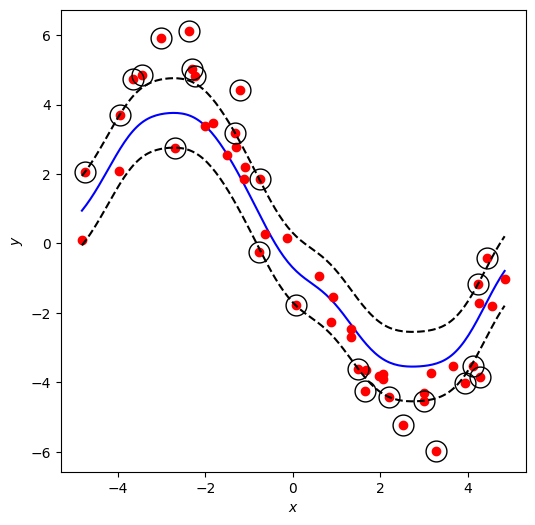

In [ ]:
model = SMORegression()
model.fit(x_train, y_train)
model.plot1D(x_train, y_train)
print(f'b = {model.b}')

#**Relevance Vector Machines**

In [ ]:
from pickle import NONE
def zero_order(x):
  return x ** 0

def first_order(x):
  return x ** 1

def second_order(x):
  return x ** 2

def third_order(x):
  return x ** 3

def exp(x):
  return np.e ** x

def sigmoid(x):
  return 1 / (1 + np.e ** (-x))

class RVM:
  def __init__(self, ):
    self.alpha_ = None
    self.beta = None
    self.m = None
    self.Sigma = None
    self.basis_functions = [zero_order, first_order, second_order, third_order, exp, sigmoid]

    self.dropIndex = None
    self.Relevance_vector_m = None


  def fitBayesian(self, X__, t_):
    phi = np.concatenate([func(X__) for func in self.basis_functions], axis = 1)
    N, M = phi.shape[0], phi.shape[1]
    beta = np.random.random(1)[0]
    alpha_ = np.random.random(M,)

    Sigma = inv(np.diag(alpha_) + beta * phi.T @ phi)
    m = beta * Sigma @ phi.T @ t_

    gamma = 1 - (np.diag(alpha_) * Sigma).sum(1)

    alpha_new_ = gamma / (m ** 2)
    beta_new = (((t_ - phi @ m) ** 2).sum() / (N - gamma.sum())) ** (-1)

    self.alpha_ = alpha_new_
    self.beta = beta_new
    self.m = m
    self.Sigma = Sigma
    self.train_X__ = None


  def fitRVM(self, X__, t_):
    self.train_X__ = X__
    phi = RBFKernelFunction(X__, X__)  # N * M
    N, M = phi.shape[0], phi.shape[1]

    beta = np.random.random(1)[0]
    alpha_ = np.ones((M,)) * 1000000


    for i in range(0, len(self.basis_functions)):
      A = np.diag(alpha_)


      Sigma = inv(A + beta * phi.T @ phi)
      m = beta * Sigma @ phi.T @ t_

      C = 1 / beta * np.eye(N) + phi @ inv(A) @ phi.T

      phi_i = phi[:, i]
      phi_i = phi_i.reshape(len(phi_i), 1)  # 50 * 1

      Q = phi_i.T @ inv(C) @ t_
      S = phi_i.T @ inv(C) @ phi_i

      q = alpha_[i] * Q / (alpha_[i] - S)
      s = alpha_[i] * S / (alpha_[i] - S)

      if q**2 > s and alpha_[i] < 1000000:
        alpha_[i] = s**2 / (q**2 - s)
      elif q**2 > s and alpha_[i] == 1000000:
        alpha_[i] = s**2 / (q**2 - s)
      elif q**2 <= s and alpha_[i] < 1000000:
        alpha_[i] = 1000000
      else:
        print("problem condition")


    Sigma = inv(np.diag(alpha_) + beta * phi.T @ phi)
    m = beta * Sigma @ phi.T @ t_

    gamma = 1 - (np.diag(alpha_) * Sigma).sum(1)
    beta_new = (((t_ - phi @ m) ** 2).sum() / (N - gamma.sum())) ** (-1)

    self.alpha_ = alpha_
    self.beta = beta_new
    self.m = m
    self.Sigma = Sigma
    print(self.m.shape)
    self.dropIndex = np.where(self.alpha_ >= 1000000)
    print(self.dropIndex)
    self.Relevance_vector_m = np.delete(self.m, self.dropIndex)


  def pred(self, X__):
    Phi = []
    for i in range(len(X__)):
      phi = RBFKernelFunction(X__[i], self.train_X__)
      phi = np.delete(phi, self.dropIndex)
      Phi.append(phi)
    Phi = np.array(Phi)
    return Phi @ self.Relevance_vector_m


problem condition
(50,)
(array([ 1,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21,
       22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38,
       39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]),)


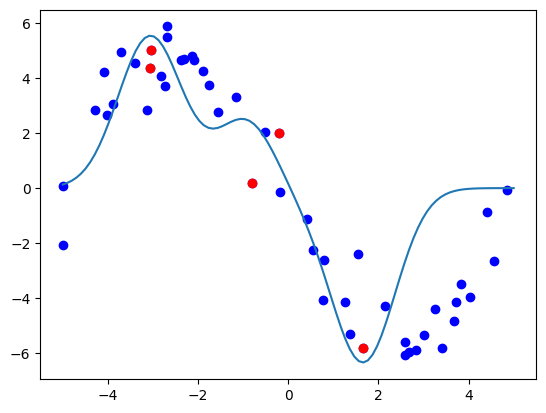

In [ ]:
model = RVM()
model.fitRVM(x_train, y_train)
x = np.linspace(-5, 5, 100)[:, np.newaxis]
pred = model.pred(x)

plt.plot(x.reshape(100), pred)
plt.scatter(x_train, y_train, c = 'b')
for i in range(0, len(y_train)):
  if model.alpha_[i] < 1000000:
    plt.scatter(x_train[i], y_train[i], c = 'r')

In [ ]:
print(model.alpha_)

[3.03690466e-02 1.00000000e+06 2.43569857e-01 5.90071553e-02
 5.20598847e-01 2.48407533e-02 1.00000000e+06 1.00000000e+06
 1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
 1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
 1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
 1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
 1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
 1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
 1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
 1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
 1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
 1.00000000e+06 1.00000000e+06 1.00000000e+06 1.00000000e+06
 1.00000000e+06 1.00000000e+06]
